# How to crop AIA and STEREO images for perspective comparison

How to set up the cropping parameters and display settings for comparing the two perspectives for a solar event. If you need to first collect a pair of AIA / STEREO images, please see [eg_aia_stereo_fetch.ipynb](eg_aia_stereo_fetch.ipynb).

First import the necessary packages.

In [1]:
import aiastereo as aist

import sunpy

from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import matplotlib.pyplot as plt
%matplotlib inline

Also, adjust the settings for this run.

**LOOP_DIR**, **LOOP_FNAME** and **FITS_DIR** are customizable. 

If **default_crop** is `True`, set EITHER **lat and lon** OR set **use_loop_params** to `True` and have a `loop_params` file ready at **LOOP_DIR + LOOP_FNAME**

Change **target_wavelength** to the appropriate wavelengths of your gathered images. 

In [2]:
default_crop = True                 # Boolean for either manual or default cropping
use_loop_params = True              # Boolean for whether or not to extract 
                                    # center from loop parameters

lat, lon = 0 * u.deg, 0 * u.deg     # Latitude and Longitude coordinates of loop
                                    # (Center coordinate for crop in degrees)

aia_crop_lims = {                   # Manual limits for aia cropping (arcseconds)
    'blox': 800,                    # Bottom Left Corner, X Coordinate
    'bloy': -400,                   # Bottom Left Corner, Y Coordinate
    'trox': 1100,                   # Top Right Corner, X Coordinate
    'troy': -100,                   # Top Right Corner, Y Coordinate
}
stereo_crop_lims = {                # Manual limits for stereo cropping (arcseconds)
    'blox': -650,                   # Bottom Left Corner, X Coordinate
    'bloy': -450,                   # Bottom Left Corner, Y Coordinate
    'trox': -350,                   # Top Right Corner, X Coordinate
    'troy': -150,                   # Top Right Corner, Y Coordinate
}

target_wavelength = 171             # Wavelength for images

LOOP_DIR = './loop_params/'         # Folder containing loop parameters
LOOP_FNAME = 'aistloop_171.pkl'     # Name for loop file to be manually loded
FITS_DIR = './observations/'        # Download folder for FITS images
CROPPED_DIR = './observations_cropped/'

Start by ensuring that the images used in this procedure are of the same filter wavelength. This cell will find all matching pairs at the **FITS_DIR** path.

In [3]:
# Finds pairs of FITS files with different instruments but equal filter wavelengths
matching_pairs = aist.find_matching_fits(FITS_DIR)

for pair in matching_pairs:
  print(f"Matching pair: {pair[0]}, {pair[1]}") 

Matching pair: ./observations/aia_lev1_171a_2012_07_19t10_14_11_34z_image_lev1.fits, ./observations/20120719_101400_n4eua.fts
Matching pair: ./observations/aia.lev1.304A_2012-07-19T10_36_19.12Z.image_lev1.fits, ./observations/20120719_103615_n4euA.fts
Matching pair: ./observations/aia.lev1.193A_2012-07-19T10_40_30.84Z.image_lev1.fits, ./observations/20120719_104030_n4euA.fts


This cell selects the pair matching the **target_wavelength** set above.

In [4]:
# Select select wavelength for matching pair
pair = aist.select_pair_by_wavelength(matching_pairs, target_wavelength)
print(pair)

('./observations/aia_lev1_171a_2012_07_19t10_14_11_34z_image_lev1.fits', './observations/20120719_101400_n4eua.fts')


And here is where **aia_map** and **stereo_map** are initialized, chosen from the respective pair element.

In [5]:
# Assign AIA and STEREO maps to those loaded from the FITS files
pair_maps = [sunpy.map.Map(item) for item in pair]

# Load AIA and SDO maps
aia_map = None
stereo_map = None
for m in pair_maps:
    if m.meta['TELESCOP'] == 'SDO/AIA':
        aia_map = m
    elif m.meta['TELESCOP'] == 'STEREO':
        stereo_map = m
    else:
        print('Pair contains maps from non AIA / STEREO instruments')

# Final check
print(aia_map.instrument, aia_map.wavelength, stereo_map.instrument, stereo_map.wavelength)


AIA 3 171.0 Angstrom SECCHI 171.0 Angstrom


Plot the paired maps to ensure the correct selection was made.

2025-03-19 17:49:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-19 17:49:14 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


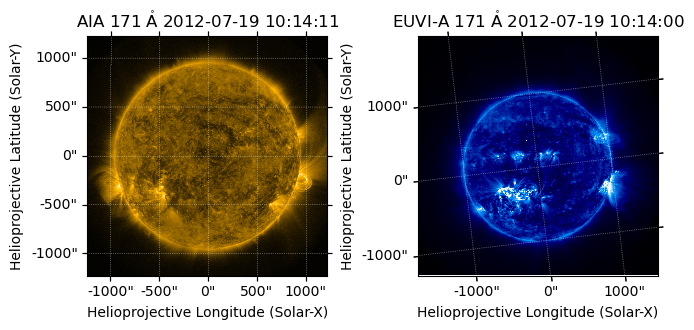

In [6]:
# Create figure with subplots
fig = plt.figure()
subfigs = fig.subfigures(1, 2, wspace=0.07)

ax1 = subfigs[0].add_subplot(projection=aia_map)
aia_map.plot(axes=ax1)

ax2 = subfigs[1].add_subplot(projection=stereo_map)
stereo_map.plot(axes=ax2)

plt.show()

Now, let's crop both maps to the preferred ROI. Specify the bottom left and top right coordinates in **aia_crop_lims** and **stereo_crop_lims** above, or have a way to collect **center** coordinates from an existing `loop_params` file.

In [7]:
# Set default crop limits
if default_crop:

    if use_loop_params:
        import pickle
        with open(LOOP_DIR + LOOP_FNAME, 'rb') as f:
            loop_params = pickle.load(f)
            f.close()
        center = (loop_params['phi0'], loop_params['theta0'])
    else:
        center = (lon, lat)
        
    center_aia = SkyCoord(lon=center[0], lat=center[1], radius=const.R_sun, 
                        frame='heliographic_stonyhurst',
                        observer=aia_map.observer_coordinate, obstime=aia_map.coordinate_frame.obstime) \
                        .transform_to(frame='helioprojective')

    center_stereo = SkyCoord(lon=center[0], lat=center[1], radius=const.R_sun, 
                            frame='heliographic_stonyhurst',
                            observer=stereo_map.observer_coordinate, obstime=aia_map.coordinate_frame.obstime) \
                            .transform_to(frame='helioprojective')

    window = 200    # Width and height of automatic window in arcseconds
    default_aia_crop_lims = {
        'blox': center_aia.Tx.value - window,
        'bloy': center_aia.Ty.value - window,
        'trox': center_aia.Tx.value + window,
        'troy': center_aia.Ty.value + window,
    }

    default_stereo_crop_lims = {
        'blox': center_stereo.Tx.value - window,
        'bloy': center_stereo.Ty.value - window,
        'trox': center_stereo.Tx.value + window,
        'troy': center_stereo.Ty.value + window,
    }

    aia_crop_lims = default_aia_crop_lims
    stereo_crop_lims = default_stereo_crop_lims

# Rotate the STEREO map to match gridlines with AIA map
stereo_map = stereo_map.rotate()

# Crop maps
aia_map_roi = aist.crop_map(aia_map, **aia_crop_lims)
stereo_map_roi = aist.crop_map(stereo_map, **stereo_crop_lims)

# Calculate pixel limits for display
aia_lims_xpix, aia_lims_ypix = aist.calc_lims(aia_crop_lims, aia_map_roi)
stereo_lims_xpix, stereo_lims_ypix = aist.calc_lims(stereo_crop_lims, stereo_map_roi)

# Overwrite the original maps with the cropped versions
aia_map = aia_map_roi
stereo_map = stereo_map_roi


/home/gabriel/miniforge3/envs/rad_transfer/lib/python3.10/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/gabriel/miniforge3/envs/rad_transfer/lib/python3.10/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]
2025-03-19 17:49:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-19 17:49:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-19 17:49:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-19 17:49:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


Display the cropped maps to ensure your intended feature is visible in both.

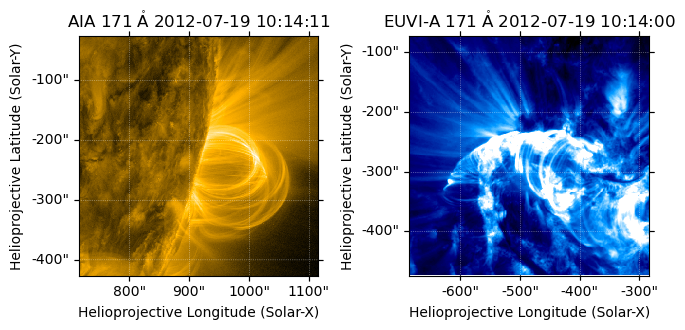

In [8]:
# Create figure with subplots
fig = plt.figure()
subfigs = fig.subfigures(1, 2, wspace=0.07)

ax1 = subfigs[0].add_subplot(projection=aia_map)
aia_map.plot(axes=ax1)

ax2 = subfigs[1].add_subplot(projection=stereo_map)
stereo_map.plot(axes=ax2)

plt.show()

Lets save the cropped images for later use.

In [18]:
obstime = aia_map.meta['date-obs']
aia_map.save(f'{CROPPED_DIR}{target_wavelength}_AIA_{obstime}.fits', overwrite=True)
obstime = stereo_map.meta['date-obs']
stereo_map.save(f'{CROPPED_DIR}{target_wavelength}_STEREO_{obstime}.fits', overwrite=True)

With your images now paired and cropped, you can move onto [creating your first CLB loop parameters](eg_clb_loop.ipynb).